In [2]:
import pandas as pd
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt

In [3]:
# Load the data
y_data = pd.read_csv("Data.csv", header=None).values
t_data = pd.read_csv("Time.csv", header=None).values.ravel()
u_g_data = np.loadtxt("ElCentro.txt")
dt_u_g = 0.02
# Interpolate the ground acceleration data to match the t_data
t_u_g = np.linspace(0, t_data[-1], len(u_g_data), endpoint=True)
u_g = np.interp(t_data, t_u_g, u_g_data)

# Define the data used
A_h = - u_g - np.gradient(y_data[:, 1], t_data)
A_h = np.expand_dims(A_h, axis=1)

# Print
print(A_h.shape)

(6581, 1)


In [4]:
# Augemented data
Z_a = np.hstack([y_data[:,[0,1,3]], A_h]) # [x, x', e, A_h]
print(Z_a.shape)

(6581, 4)


In [5]:
# Create custom library for Z_a
# Define the function
polynomial_library = ps.PolynomialLibrary(degree=3)
Z_h_func = [lambda x0,x1,x2,x3: np.abs(x1), lambda x0,x1,x2,x3: np.abs(x3)]
Z_h = ps.CustomLibrary(library_functions=Z_h_func)
Z_h_tensor = ps.TensoredLibrary([Z_h, Z_h])
U = ps.IdentityLibrary().fit(np.expand_dims(u_g, axis=1))
lib = ps.ConcatLibrary([polynomial_library , Z_h_tensor, U])


In [6]:
# Check
Z_h_tensor.fit(Z_a)
print(Z_h_tensor.get_feature_names())

['f0(x0,x1,x2,x3) f0(x0,x1,x2,x3)', 'f0(x0,x1,x2,x3) f1(x0,x1,x2,x3)', 'f1(x0,x1,x2,x3) f0(x0,x1,x2,x3)', 'f1(x0,x1,x2,x3) f1(x0,x1,x2,x3)']


In [7]:
# Use pysindy to find the best fit model
optimizer = ps.STLSQ(threshold=0.1, alpha=0.5)
model = ps.SINDy(feature_library=lib, optimizer=optimizer, feature_names=["x", "x_dot", "e", "A_h"])
model.fit(Z_a, t=t_data, unbias=False)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=<pysindy.feature_library.base.ConcatLibrary object at 0x0000027175FD00D0>,
      feature_names=['x', 'x_dot', 'e', 'A_h'], optimizer=STLSQ(alpha=0.5))

In [8]:
model.print()
print("Model score: %f" % model.score(x=Z_a, t=t_data))

(x)' = 0.473 x_dot + 0.473 x_dot
(x_dot)' = 0.410 x + 3.194 x_dot + -0.306 A_h + 0.470 x e + 0.214 x_dot^2 + -0.251 x_dot e + -1.078 x_dot A_h + -0.275 x e^2 + -0.593 x e A_h + 0.560 x A_h^2 + 0.645 x_dot^2 e + -0.109 x_dot^2 A_h + 0.214 f0(x,x_dot,e,A_h) f0(x,x_dot,e,A_h) + 0.710 f0(x,x_dot,e,A_h) f1(x,x_dot,e,A_h) + 0.710 f1(x,x_dot,e,A_h) f0(x,x_dot,e,A_h) + 0.410 x + 3.194 x_dot + -0.306 A_h
(e)' = -0.735 x + 1.965 x_dot + 0.107 x x_dot + -2.302 x e + 0.531 x A_h + -1.693 x_dot^2 + -6.450 x_dot e + 61.484 x_dot A_h + 0.436 x x_dot e + -0.141 x e^2 + -0.929 x e A_h + 1.886 x A_h^2 + -26.265 x_dot^2 e + 0.930 x_dot^2 A_h + 0.481 x_dot e^2 + 4.149 x_dot e A_h + 6.345 x_dot A_h^2 + -1.693 f0(x,x_dot,e,A_h) f0(x,x_dot,e,A_h) + 0.805 f0(x,x_dot,e,A_h) f1(x,x_dot,e,A_h) + 0.805 f1(x,x_dot,e,A_h) f0(x,x_dot,e,A_h) + -0.735 x + 1.965 x_dot
(A_h)' = -1.784 x + 356.093 x_dot + 0.341 x x_dot + -3.040 x e + -10.614 x A_h + 16.915 x_dot^2 + 73.874 x_dot e + -94.463 x_dot A_h + -0.356 e A_h + -1.

In [11]:
model.equations()

['0.473 x_dot + 0.473 x_dot',
 '0.410 x + 3.194 x_dot + -0.306 A_h + 0.470 x e + 0.214 x_dot^2 + -0.251 x_dot e + -1.078 x_dot A_h + -0.275 x e^2 + -0.593 x e A_h + 0.560 x A_h^2 + 0.645 x_dot^2 e + -0.109 x_dot^2 A_h + 0.214 f0(x,x_dot,e,A_h) f0(x,x_dot,e,A_h) + 0.710 f0(x,x_dot,e,A_h) f1(x,x_dot,e,A_h) + 0.710 f1(x,x_dot,e,A_h) f0(x,x_dot,e,A_h) + 0.410 x + 3.194 x_dot + -0.306 A_h',
 '-0.735 x + 1.965 x_dot + 0.107 x x_dot + -2.302 x e + 0.531 x A_h + -1.693 x_dot^2 + -6.450 x_dot e + 61.484 x_dot A_h + 0.436 x x_dot e + -0.141 x e^2 + -0.929 x e A_h + 1.886 x A_h^2 + -26.265 x_dot^2 e + 0.930 x_dot^2 A_h + 0.481 x_dot e^2 + 4.149 x_dot e A_h + 6.345 x_dot A_h^2 + -1.693 f0(x,x_dot,e,A_h) f0(x,x_dot,e,A_h) + 0.805 f0(x,x_dot,e,A_h) f1(x,x_dot,e,A_h) + 0.805 f1(x,x_dot,e,A_h) f0(x,x_dot,e,A_h) + -0.735 x + 1.965 x_dot',
 '-1.784 x + 356.093 x_dot + 0.341 x x_dot + -3.040 x e + -10.614 x A_h + 16.915 x_dot^2 + 73.874 x_dot e + -94.463 x_dot A_h + -0.356 e A_h + -1.565 A_h^2 + -0.219 x

In [9]:
# Simulate
# Extract time each 10 seconds
t_sim = np.arange(0, 10, 1)
Z_dot_sim = model.predict(Z_a)
print(Z_dot_sim.shape)

(6581, 4)


In [ ]:
# Integrate to get the simulation
from scipy.integrate import odeint

def f(z, t):
    


Text(0.5, 0.98, 'Velocity')

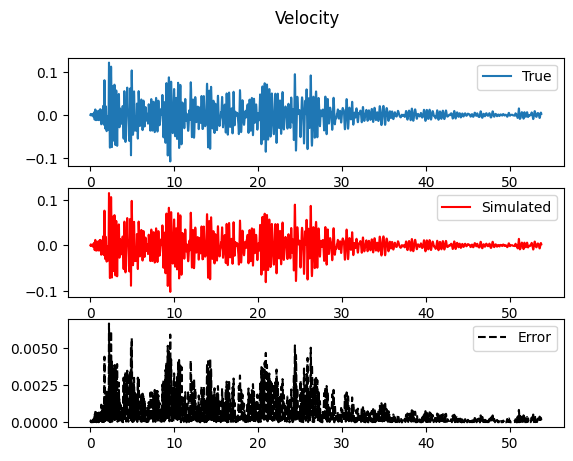

In [32]:
# Plot into two subplots
fig, axs = plt.subplots(3)
axs[0].plot(t_data, y_data[:, 1], label='True')
axs[0].legend()

axs[1].plot(t_data, Z_dot_sim[:, 0], label='Simulated', color='red')
axs[1].legend()

axs[2].plot(t_data, np.abs(y_data[:,1] - Z_dot_sim[:,0]), '--k', label='Error')
axs[2].legend()

plt.suptitle("Velocity")

In [34]:
# Get Z_a
Z_sim = model.simulate(Z_a[0,:], t=t_data)

Text(0.5, 0.98, 'Displacement')

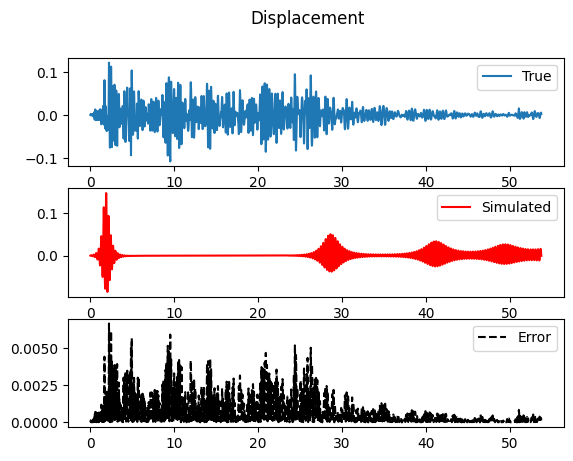

In [45]:
fig, axs = plt.subplots(3)
axs[0].plot(t_data, y_data[:, 1], label='True')
axs[0].legend()

axs[1].plot(t_data, Z_sim[:,1], label='Simulated', color='red')
axs[1].legend()

axs[2].plot(t_data, np.abs(y_data[:,1] - Z_dot_sim[:,0]), '--k', label='Error')
axs[2].legend()

plt.suptitle("Displacement")

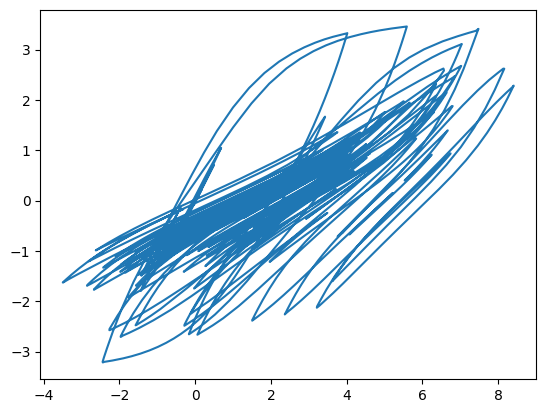

In [43]:
# Plot histeresis

## Import real parameters
real_params = pd.read_csv("params_real.csv", header=None).values.ravel()
Res_force_real = real_params * y_data[:,2] / 1e3

plt.plot(y_data[:,0]*1e3, Res_force_real, label='Real')
